# Description

TODO

# Modules

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from langchain.cache import SQLiteCache
from langchain.globals import set_llm_cache
from proj import conf
from proj.utils import llm_pairwise

# Settings/paths

In [22]:
# # Input manuscript
# REPO = None

# INPUT_FILE = None
# OUTPUT_FILE = None

# # Model and its parameters
# LLM_JUDGE = None
# TEMPERATURE = None
# MAX_TOKENS = 2000
# SEED_INIT = 0

# # Evaluation parameters
# N_REPS = None

In [23]:
INPUT_DIR = conf.common.LLM_PAIRWISE_DIR
assert INPUT_DIR.exists()
display(INPUT_DIR)

PosixPath('/home/miltondp/projects/others/manubot/manubot-ai-editor-code/base/results/llm_pairwise')

# Load LLM pairwise files

In [24]:
result_files = list(INPUT_DIR.glob("*.pkl"))
display(len(result_files))
display(result_files[:2])

20

[PosixPath('/home/miltondp/projects/others/manubot/manubot-ai-editor-code/base/results/llm_pairwise/epistasis-manuscript--gpt-3.5-turbo--openai_gpt-3.5-turbo.pkl'),
 PosixPath('/home/miltondp/projects/others/manubot/manubot-ai-editor-code/base/results/llm_pairwise/phenoplier-manuscript--gpt-3.5-turbo--openai_gpt-3.5-turbo.pkl')]

In [25]:
pd.read_pickle(result_files[0])

,rep_index,paragraph_index,paragraph_section,winner,rationale,winner_score
0,0,0,abstract,Paragraph 1,Paragraph 1 slightly edges out Paragraph A in ...,1.0
1,0,1,introduction,tie,Both paragraphs exhibit clear sentence structu...,0.0
2,0,2,introduction,Paragraph 1,Paragraph 1 is slightly better due to the abse...,1.0
3,0,3,introduction,Paragraph 1,Both paragraphs exhibit clear sentence structu...,1.0
4,0,4,introduction,Paragraph 1,Both paragraphs exhibit clear sentence structu...,1.0
...,...,...,...,...,...,...
310,4,58,methods,tie,Both paragraphs exhibit clear sentence structu...,0.0
311,4,59,methods,Paragraph A,Paragraph A excels in having a clear sentence ...,-1.0
312,4,60,methods,Paragraph 1,Paragraph 1 is slightly better due to maintain...,1.0
313,4,61,methods,tie,Both paragraphs exhibit clear sentence structu...,0.0


In [26]:
result_files[0].name.split("--")

['epistasis-manuscript', 'gpt-3.5-turbo', 'openai_gpt-3.5-turbo.pkl']

In [27]:
all_results = []

for f in result_files:
    print(f.name, flush=True)
    df = pd.read_pickle(f)
    
    f_name_parts = f.name.split("--")
    idx = 0
    manuscript_code = f_name_parts[idx]
    manuscript_code = manuscript_code.split("-manuscript")[0]
    idx += 1
    
    manuscript_pr_model = f_name_parts[idx]
    idx += 1

    reversed_paragraphs = False
    if len(f_name_parts) > 3:
        reversed_paragraphs = f_name_parts[idx] == "reversed"
        idx += 1
    
    llm_judge = f_name_parts[idx].split(".pkl")[0]

    df.insert(0, "llm_judge", llm_judge)
    df.insert(0, "paragraphs_reversed", reversed_paragraphs)
    df.insert(0, "pr_model", manuscript_pr_model)
    df.insert(0, "manuscript_code", manuscript_code)

    all_results.append(df)

epistasis-manuscript--gpt-3.5-turbo--openai_gpt-3.5-turbo.pkl
phenoplier-manuscript--gpt-3.5-turbo--openai_gpt-3.5-turbo.pkl
ccc-manuscript--gpt-3.5-turbo--anthropicai_claude-3-opus-20240229.pkl
ccc-manuscript--gpt-3.5-turbo--mistral_7b-instruct-fp16.pkl
ccc-manuscript--gpt-3.5-turbo--reversed--openai_gpt-3.5-turbo.pkl
ccc-manuscript--gpt-3.5-turbo--reversed--anthropicai_claude-3-opus-20240229.pkl
biochatter-manuscript--gpt-3.5-turbo--mistral_7b-instruct-fp16.pkl
phenoplier-manuscript--gpt-3.5-turbo--reversed--openai_gpt-3.5-turbo.pkl
biochatter-manuscript--gpt-3.5-turbo--reversed--mistral_7b-instruct-fp16.pkl
ccc-manuscript--gpt-3.5-turbo--reversed--openai_gpt-4-turbo-preview.pkl
epistasis-manuscript--gpt-3.5-turbo--openai_gpt-4-turbo-preview.pkl
biochatter-manuscript--gpt-3.5-turbo--openai_gpt-4-turbo-preview.pkl
epistasis-manuscript--gpt-3.5-turbo--reversed--openai_gpt-3.5-turbo.pkl
biochatter-manuscript--gpt-3.5-turbo--openai_gpt-3.5-turbo.pkl
ccc-manuscript--gpt-3.5-turbo--openai_

In [28]:
df = pd.concat(all_results, ignore_index=True)

In [29]:
df.shape

(4857, 10)

In [30]:
df.head()

,manuscript_code,pr_model,paragraphs_reversed,llm_judge,rep_index,paragraph_index,paragraph_section,winner,rationale,winner_score
0,epistasis,gpt-3.5-turbo,False,openai_gpt-3.5-turbo,0,0,abstract,Paragraph 1,Paragraph 1 slightly edges out Paragraph A in ...,1.0
1,epistasis,gpt-3.5-turbo,False,openai_gpt-3.5-turbo,0,1,introduction,tie,Both paragraphs exhibit clear sentence structu...,0.0
2,epistasis,gpt-3.5-turbo,False,openai_gpt-3.5-turbo,0,2,introduction,Paragraph 1,Paragraph 1 is slightly better due to the abse...,1.0
3,epistasis,gpt-3.5-turbo,False,openai_gpt-3.5-turbo,0,3,introduction,Paragraph 1,Both paragraphs exhibit clear sentence structu...,1.0
4,epistasis,gpt-3.5-turbo,False,openai_gpt-3.5-turbo,0,4,introduction,Paragraph 1,Both paragraphs exhibit clear sentence structu...,1.0


# Process data for plotting

## Reverse scores for reversed paragraphs

In [31]:
df.loc[df["paragraphs_reversed"], "winner_score"] = -1 * df.loc[df["paragraphs_reversed"], "winner_score"]

## Rename values

In [32]:
df["llm_judge"].unique()

array(['openai_gpt-3.5-turbo', 'anthropicai_claude-3-opus-20240229',
       'mistral_7b-instruct-fp16', 'openai_gpt-4-turbo-preview'],
      dtype=object)

In [33]:
models_rename = {
    "openai_gpt-4": "GPT-4",
    "openai_gpt-4-turbo-preview": "GPT-4 Turbo",
    "openai_gpt-3.5-turbo": "GPT 3.5 Turbo",
    "mistral_7b-instruct-fp16": "Mistral 7b",
}

In [34]:
df["manuscript_code"].unique()

array(['epistasis', 'phenoplier', 'ccc', 'biochatter'], dtype=object)

In [35]:
df["paragraph_section"].unique()

array(['abstract', 'introduction', 'results', 'discussion', 'methods',
       'supplementary material'], dtype=object)

In [36]:
df = df.replace({
    "manuscript_code": {
        "biochatter": "BioChatter",
        "ccc": "CCC",
        "phenoplier": "PhenoPLIER",
        "epistasis": "Epistasis",
    },
    "pr_model": models_rename,
    "llm_judge": models_rename,
    "paragraph_section": {
        "abstract": "Abstract",
        "introduction": "Introduction",
        "results": "Results",
        "methods": "Methods",
        "discussion": "Discussion",
        "supplementary material": "Supplementary\nmaterial",
    }
})

# Plot

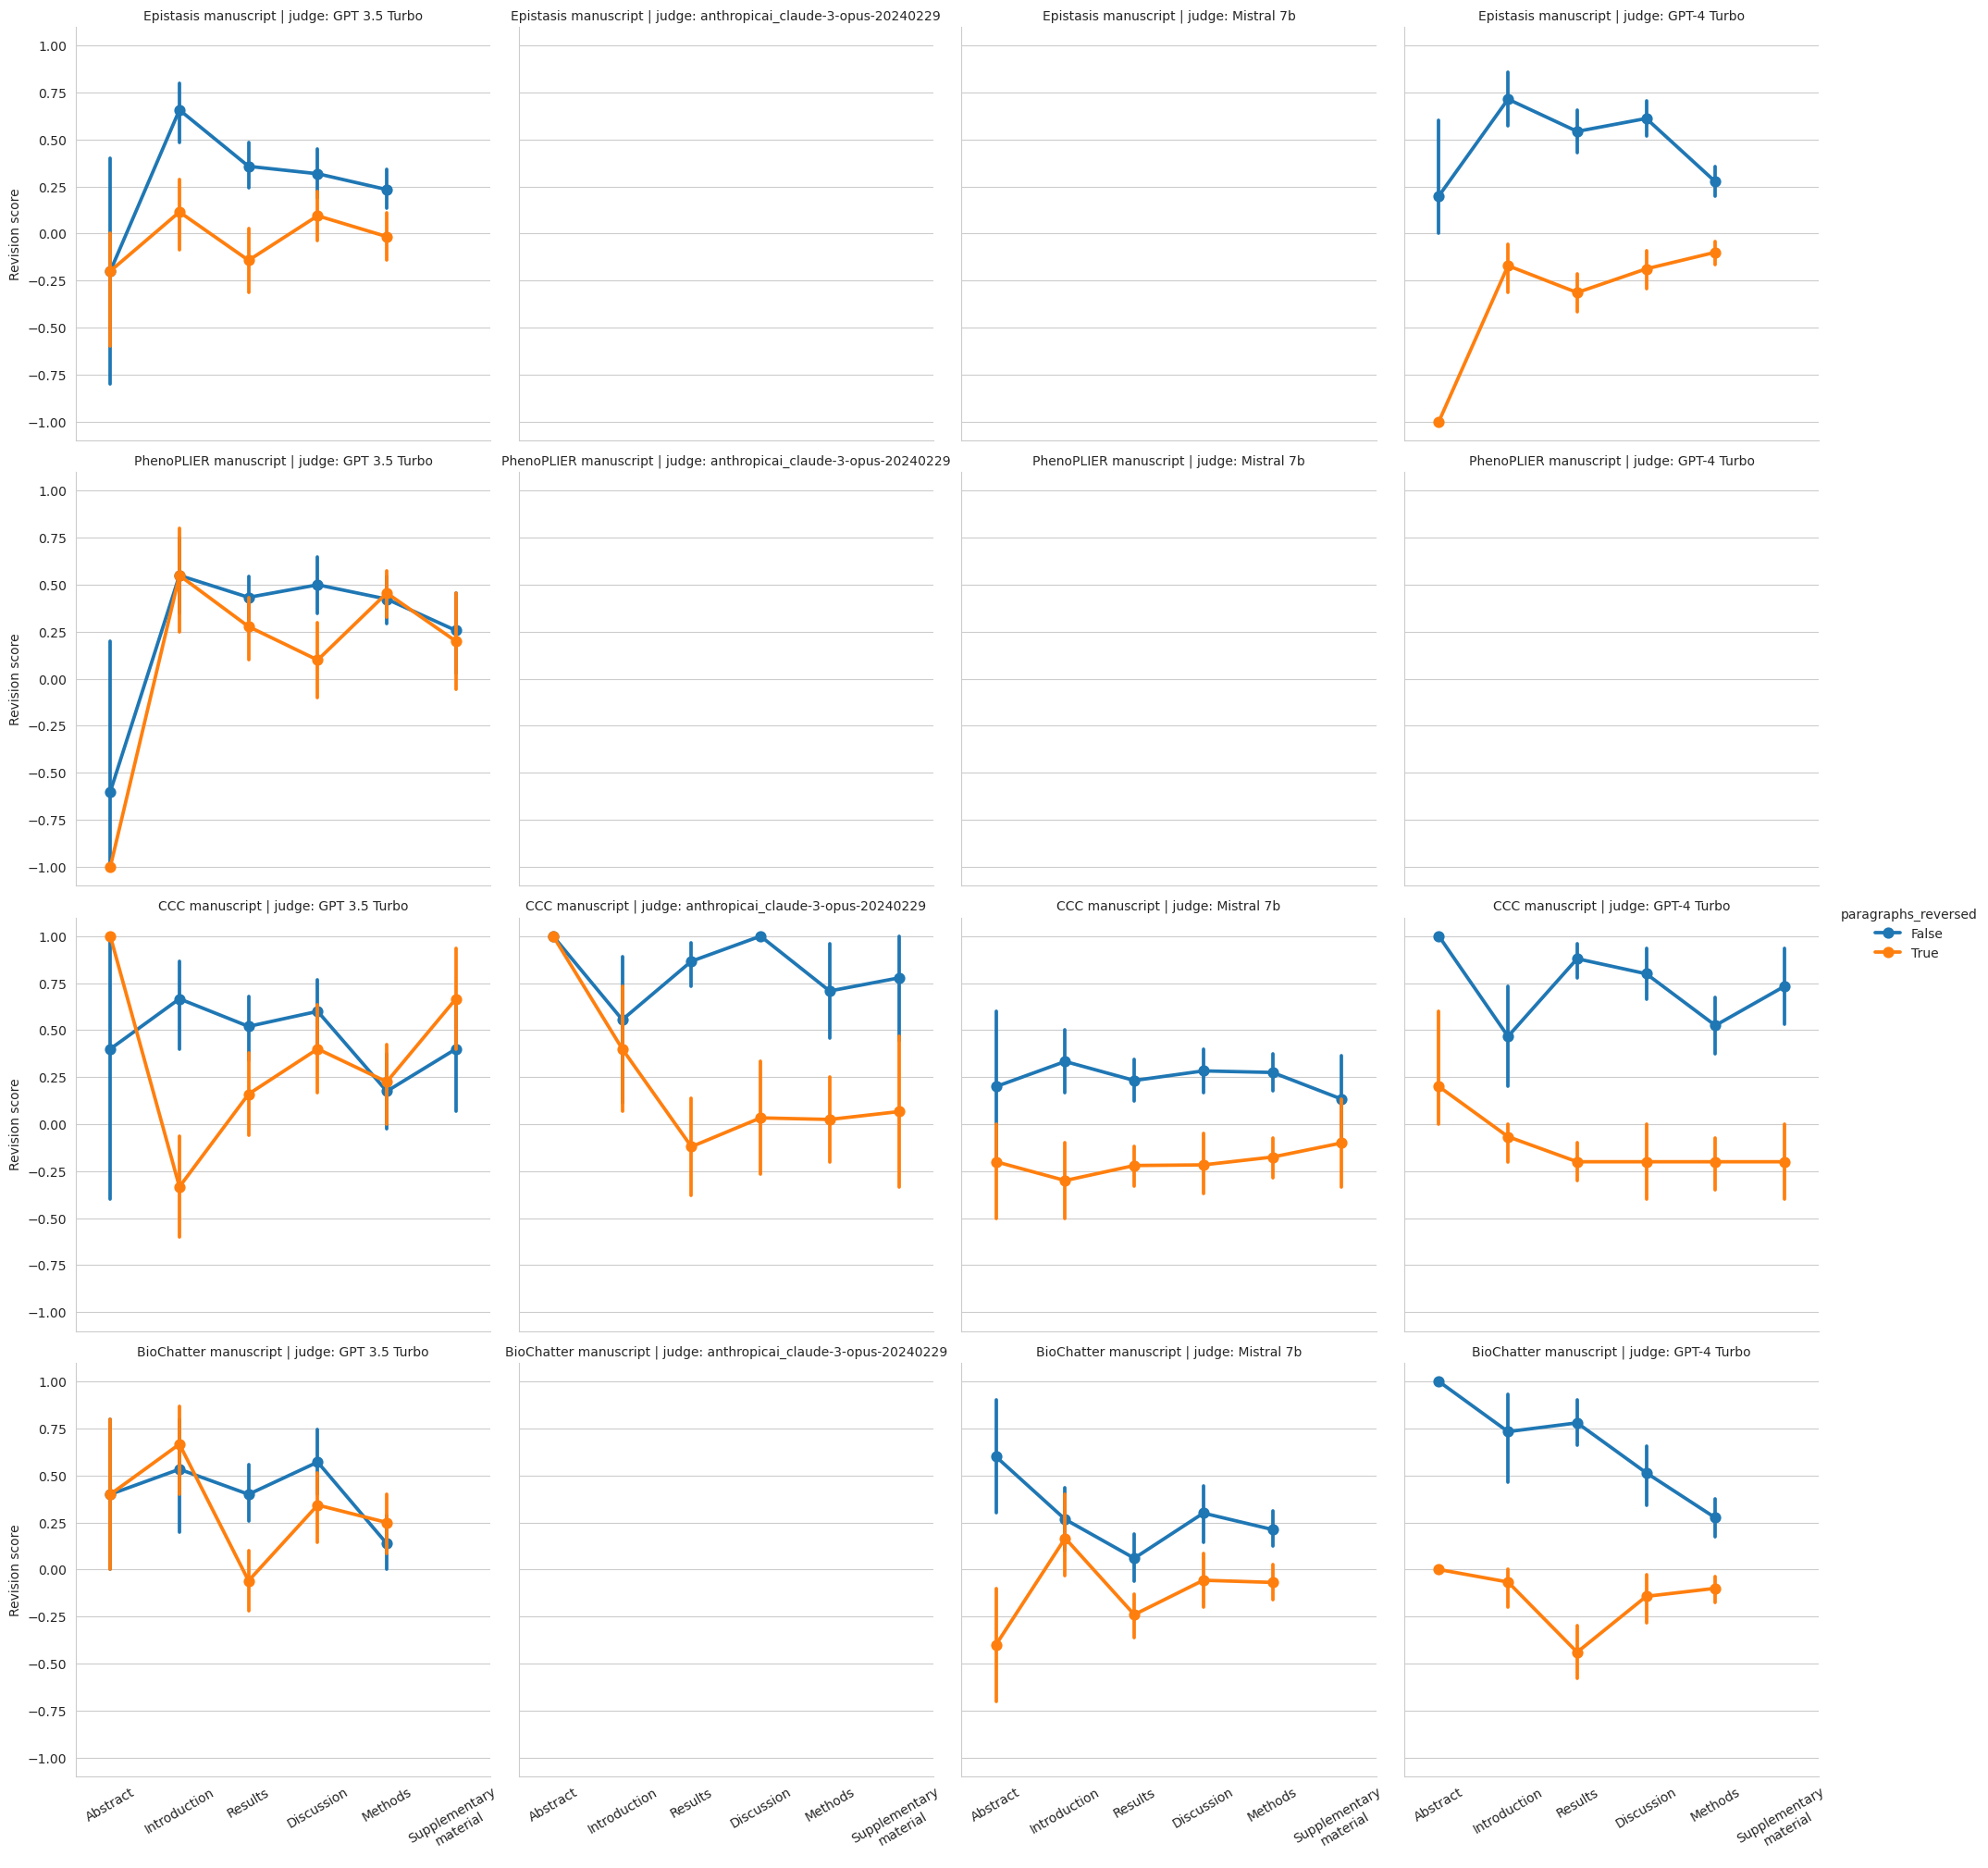

In [37]:
with sns.axes_style("whitegrid"):
    g = sns.catplot(
        data=df,
        x="paragraph_section",
        y="winner_score",
        row="manuscript_code",
        col="llm_judge",
        kind="point",
        hue="paragraphs_reversed",
    )
    g.set_axis_labels("", "Revision score")
    g.set_titles("{row_name} manuscript | judge: {col_name}")
    g.tick_params(axis='x', rotation=30)

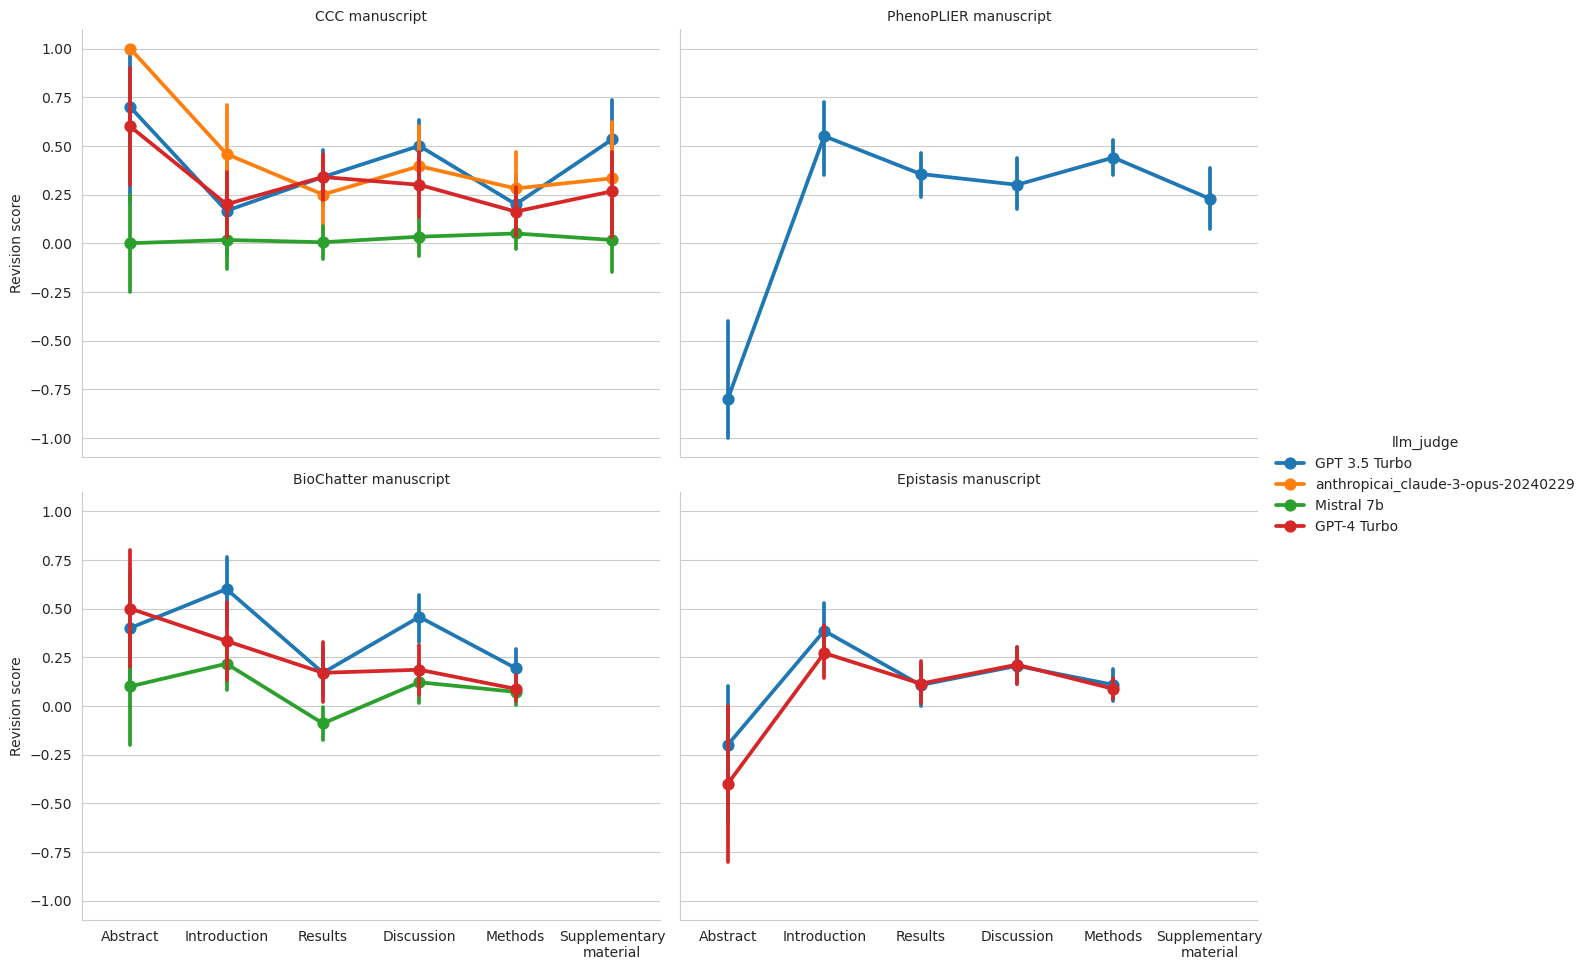

In [38]:
with sns.axes_style("whitegrid"):
    g = sns.catplot(
        height=5,
        aspect=1.3,
        data=df,
        x="paragraph_section",
        y="winner_score",
        col="manuscript_code",
        col_order=["CCC", "PhenoPLIER", "BioChatter", "Epistasis"],
        col_wrap=2,
        kind="point",
        hue="llm_judge",
    )
    g.set_axis_labels("", "Revision score")
    g.set_titles("{col_name} manuscript")
    # g.tick_params(axis='x', rotation=30)
    # g.set_xticklabels(g.ax.get_xticklabels(), rotation=30)

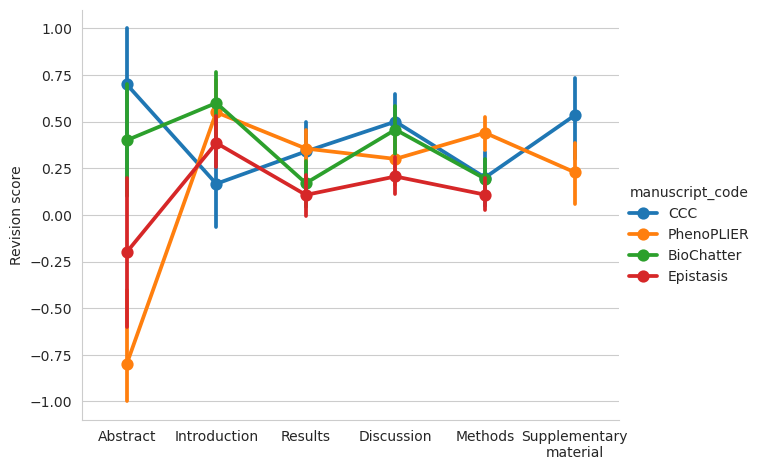

In [39]:
with sns.axes_style("whitegrid"):
    g = sns.catplot(
        height=5,
        aspect=1.3,
        data=df[df["llm_judge"] == "GPT 3.5 Turbo"],
        x="paragraph_section",
        y="winner_score",
        hue="manuscript_code",
        hue_order=["CCC", "PhenoPLIER", "BioChatter", "Epistasis"],
        # col_wrap=2,
        kind="point",
    )
    g.set_axis_labels("", "Revision score")
    g.set_titles("{col_name} manuscript")
    # g.tick_params(axis='x', rotation=30)
    # g.set_xticklabels(g.ax.get_xticklabels(), rotation=30)

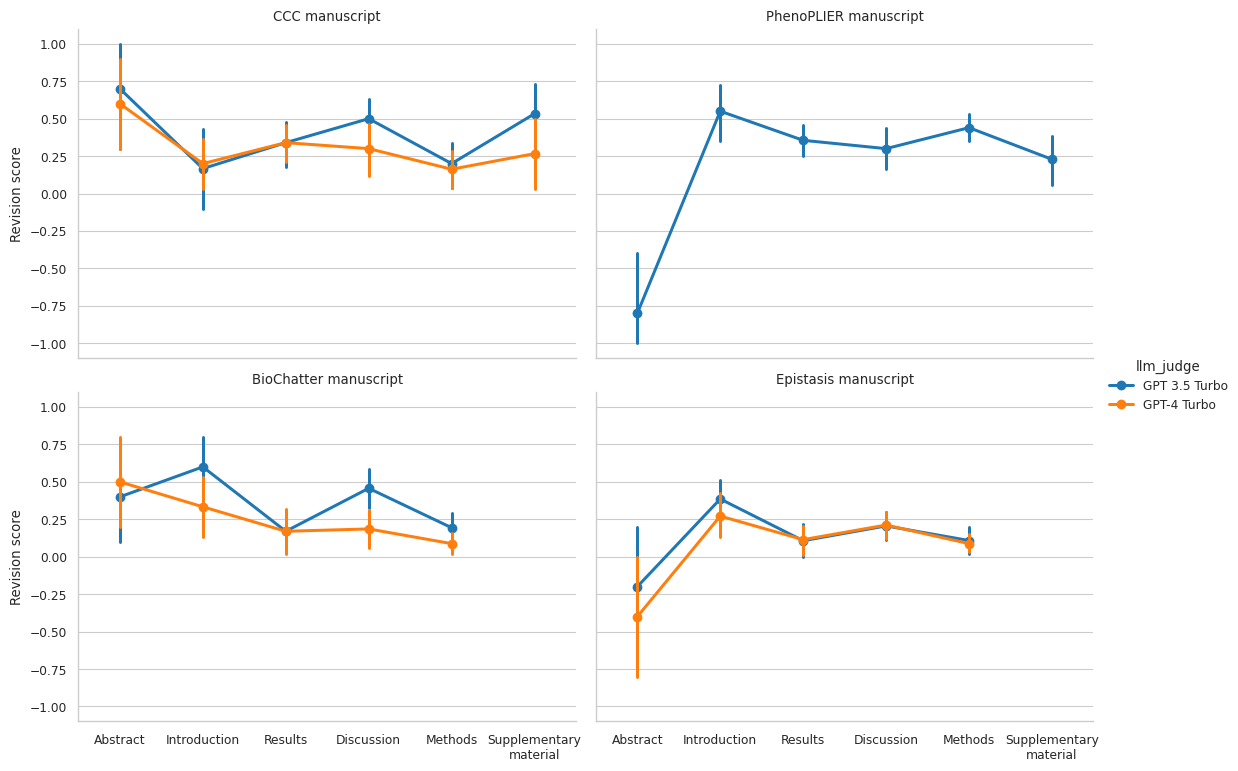

In [40]:
with sns.plotting_context("paper", font_scale=1.0), sns.axes_style("whitegrid"):
    g = sns.catplot(
        height=4,
        aspect=1.4,
        data=df[df["llm_judge"].isin(("GPT 3.5 Turbo", "GPT-4 Turbo"))],
        x="paragraph_section",
        y="winner_score",
        col="manuscript_code",
        col_order=["CCC", "PhenoPLIER", "BioChatter", "Epistasis"],
        col_wrap=2,
        kind="point",
        hue="llm_judge",
    )
    g.set_axis_labels("", "Revision score")
    g.set_titles("{col_name} manuscript")
    # g.tick_params(axis='x', rotation=30)
    # g.set_xticklabels(g.ax.get_xticklabels(), rotation=30)